In [1]:
!pip install gensim

In [2]:
from wordcloud import WordCloud

In [3]:
%matplotlib inline

### Importing the required libraries

In [4]:
import pandas as pd  #dataframe manipulation
import numpy as np # multidimensional array manipulation
import matplotlib.pyplot as plt #for visualization
import seaborn as sns
#for natural language processing
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix #to access performance of the model

/home/chinmayee/anaconda3/envs/tf/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


In [6]:
#load the data
resume_df =  pd.read_csv('resume.csv',encoding = 'latin-1')
resume_df

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
...,...,...,...
120,resume_121,not_flagged,\rBrattleboro VT - Email me on Indeed: indeed....
121,resume_122,not_flagged,\rResearch and Teaching Assistant - University...
122,resume_123,not_flagged,\rMedical Coder - Highly Skilled - Entry Level...
123,resume_124,flagged,\rWaterbury VT - Email me on Indeed: indeed.co...


Here we have
resume id,
class = 0/1, flagged/not flagged,
resume text or the actual content of the resume

In [7]:
# We do not need the column resume_id hence we will just consider the class and the resume_text
resume_df = resume_df[['resume_text','class']]
resume_df

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,not_flagged
121,\rResearch and Teaching Assistant - University...,not_flagged
122,\rMedical Coder - Highly Skilled - Entry Level...,not_flagged
123,\rWaterbury VT - Email me on Indeed: indeed.co...,flagged


### Performing exploratory data analysis

In [8]:
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


From this, we can see that we have 125 entries, 2 columns, and no null elements. 
Checking again for non-null elements, isnull()

In [9]:
resume_df.isnull()

,resume_text,class
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
120,False,False
121,False,False
122,False,False
123,False,False


As you can see the data is clean, no null elements are there

In [10]:
#Checking how many of the entries are flagged or non-flagged
resume_df['class'].value_counts()

not_flagged    92
flagged        33
Name: class, dtype: int64

This is an unbalanced dataset with 92 not-flagged entries and 33 flagged entries

In [11]:
# replacing thee values of the column class with 0/1 instead of flagged/not_flagged
resume_df['class'] = resume_df['class'].apply(lambda x:1 if x == 'flagged' else 0)
resume_df

<ipython-input-11-4ed5861a4782>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['class'] = resume_df['class'].apply(lambda x:1 if x == 'flagged' else 0)


,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
4,\rIndependent Consultant - Self-employed\rBurl...,1
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,0
121,\rResearch and Teaching Assistant - University...,0
122,\rMedical Coder - Highly Skilled - Entry Level...,0
123,\rWaterbury VT - Email me on Indeed: indeed.co...,1


In [12]:
class_0 = resume_df[resume_df['class'] == 0]
class_0.head(5)

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
5,\rPoultney VT - Email me on Indeed: indeed.com...,0


In [13]:
class_1 = resume_df[resume_df['class'] == 1]
class_1.tail(5)

,resume_text,class
114,Ph.D.\rSouth Royalton VT - Email me on Indeed...,1
115,\rEssex Jct VT - Email me on Indeed: indeed.co...,1
117,\rSpatial Analyst and UAV Flight Operator - Sp...,1
118,| Bioinformatics Analyst\rBurlington VT - Ema...,1
123,\rWaterbury VT - Email me on Indeed: indeed.co...,1


 ### Perform data cleaning
 A lot of '\r' is present in the dataset. Hence we need to clean the data

In [14]:
resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x:x.replace('\r',''))
resume_df

<ipython-input-14-7b12ae0db6dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x:x.replace('\r',''))


,resume_text,class
0,Customer Service Supervisor/Tier - Isabella Ca...,0
1,Engineer / Scientist - IBM Microelectronics Di...,0
2,LTS Software Engineer Computational Lithograph...,0
3,TUTORWilliston VT - Email me on Indeed: indee...,0
4,Independent Consultant - Self-employedBurlingt...,1
...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0
121,Research and Teaching Assistant - University o...,0
122,Medical Coder - Highly Skilled - Entry LevelSu...,0
123,Waterbury VT - Email me on Indeed: indeed.com/...,1


In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/chinmayee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chinmayee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

stopwords are common english words that do not add much value to my machine learning model. Eg., from, I, am etc.
And we need to get rid of them.

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')  #in the english language
stop_words.extend(['From','subject','re','edu','email','use','com'])

In [18]:
# Removing the stopwords and also words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

resume_df['cleaned'] = resume_df['resume_text'].apply(preprocess)
resume_df


,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...
...,...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...
123,Waterbury VT - Email me on Indeed: indeed.com/...,1,waterbury bec fcwilling relocate work employer...


Column - 'cleaned' contains the cleaned dataset with no stopwords , all lowercased and all len > 2

### Visualizing our cleaned dataset

/home/chinmayee/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


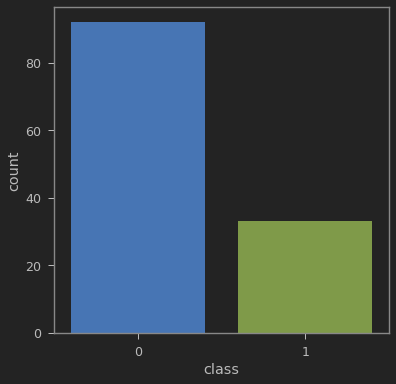

In [19]:
#Plotting the counts of flagged vs not_flagged i.e., 0 or 1
plt.figure(figsize=(6,6))
sns.countplot(resume_df['class'],label = 'Count Plot')
plt.show()

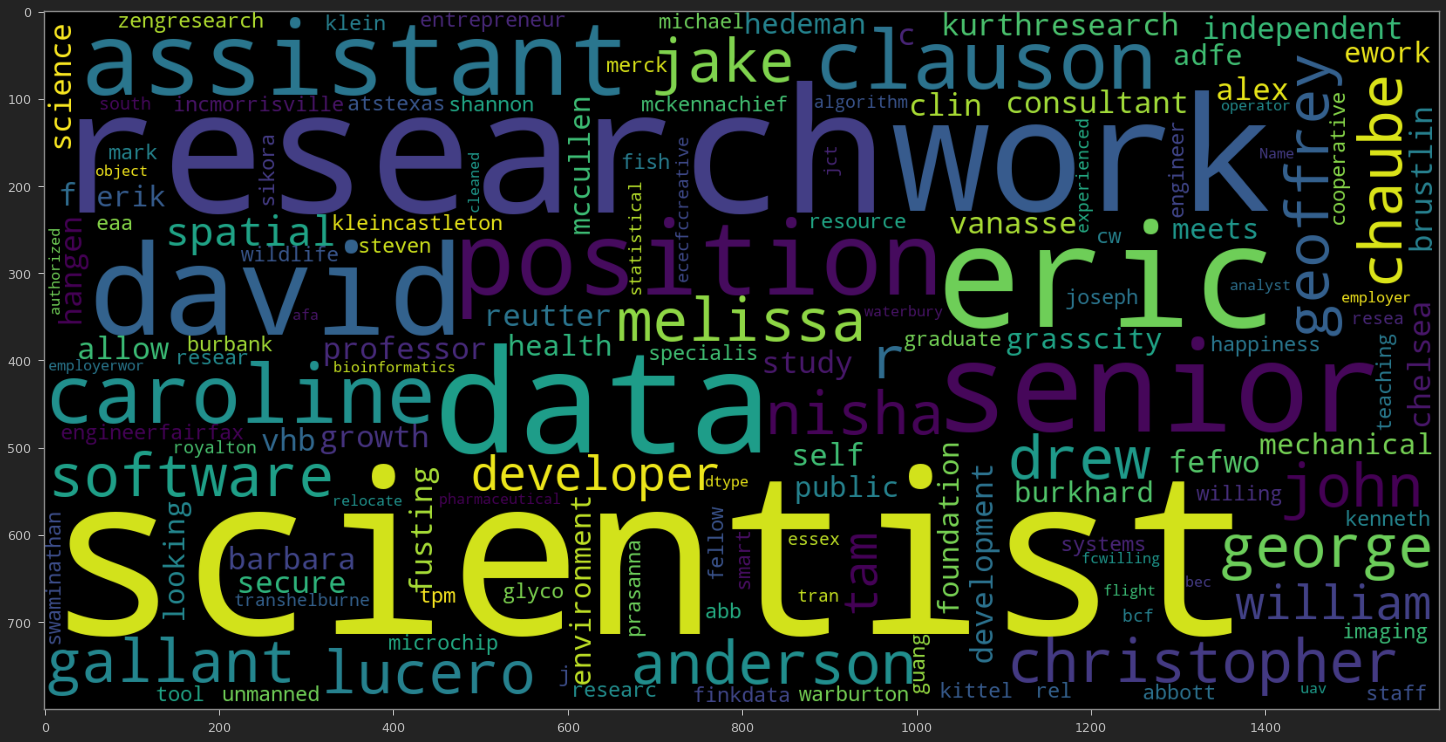

In [20]:
#plottint the wordcloud for the flagged text
plt.figure(figsize = (25,25))
wc = WordCloud(max_words = 2000, width=1600,height=800,stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 1].cleaned))
plt.imshow(wc)

The most common words we can see here are- Scientist, research, data, senior.
 From the 125 resumes the flagged ones required data scientist and hence we can the above common words.

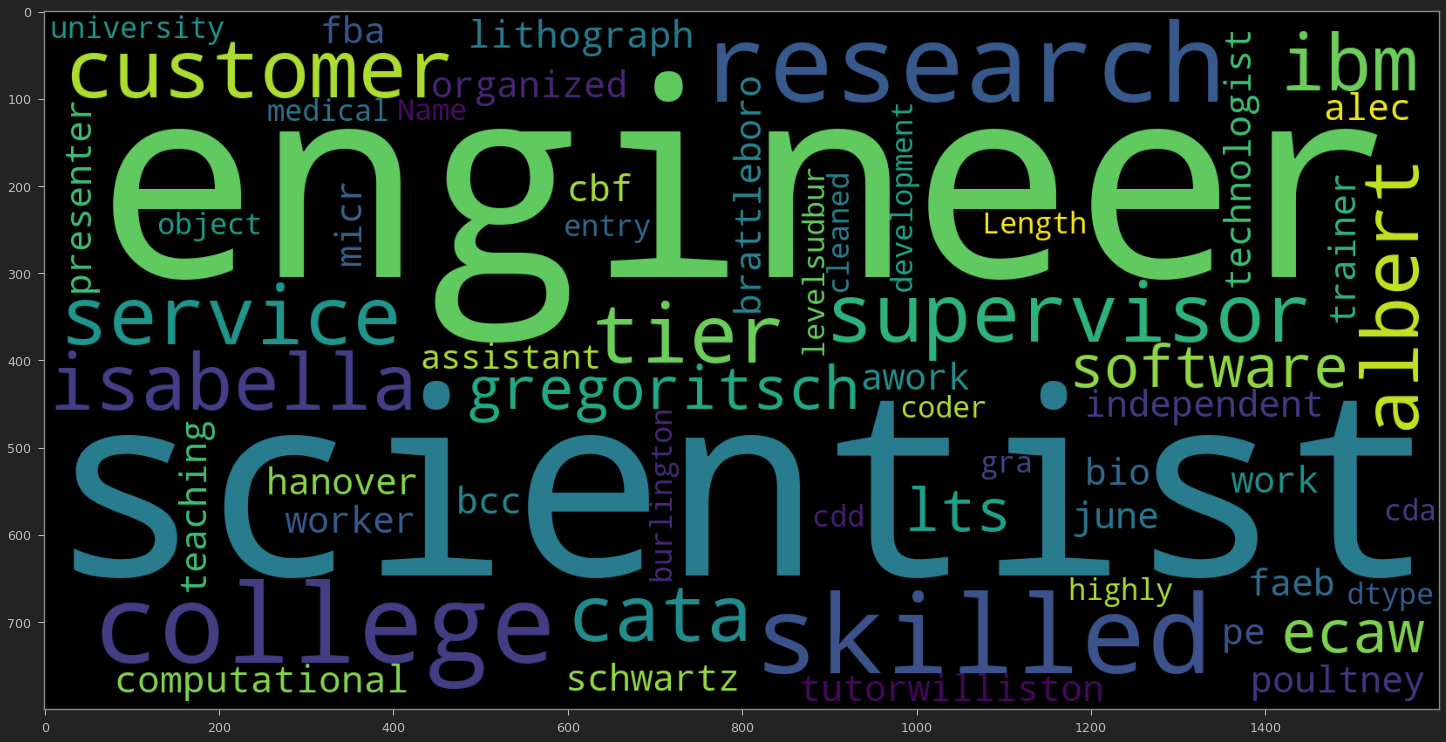

In [21]:
plt.figure(figsize = (25,25))
wc = WordCloud(max_words = 2000, width=1600,height=800,stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 0].cleaned))
plt.imshow(wc)

This shows the common words of the not_flagged resumes like scientist, engineer, college, skilled, service, customer, research etc


### Preparing the data before using them in the model by Count Vectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
countvec = vectorizer.fit_transform(resume_df['cleaned'])

# checking the unique or the feature names
print(vectorizer.get_feature_names())

['aaalac', 'aabb', 'aac', 'aacn', 'aacr', 'aacrjournals', 'aakeroõ_y', 'aanpcp', 'aaron', 'abbott', 'abdomen', 'abdominal', 'abdul', 'aberdeen', 'abi', 'abilities', 'ability', 'abiotic', 'able', 'abnormal', 'aboard', 'abosalem', 'abraham', 'abreast', 'abs', 'absence', 'absorbance', 'abstract', 'abstracta', 'abstractdisease', 'abstracted', 'abstractin', 'abstracts', 'abualrub', 'abundance', 'abureehan', 'abuse', 'abusiness', 'academia', 'academic', 'academics', 'academy', 'acaeefbc', 'accelerated', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accession', 'accident', 'accidents', 'accolateî', 'accommodations', 'accomplished', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accountability', 'accountable', 'accounted', 'accounting', 'accounts', 'accreditation', 'accredited', 'accrual', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accustomed'

In [23]:
# checking the now encoded cleaned column
print(countvec.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Naive Bayes Model

### Train Naive Bayes  Classifier Model

In [24]:
X = countvec
y = resume_df['class']
X.shape, y.shape

((125, 11314), (125,))

In [45]:
# separating the training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25)  # training = 80%, testing = 20%

In [46]:
# Training the model here
from sklearn.naive_bayes import MultinomialNB
NB_class = MultinomialNB()
NB_class.fit(X_train, y_train)

MultinomialNB()

###  Assess the trained model

confusion matrix

<AxesSubplot:>

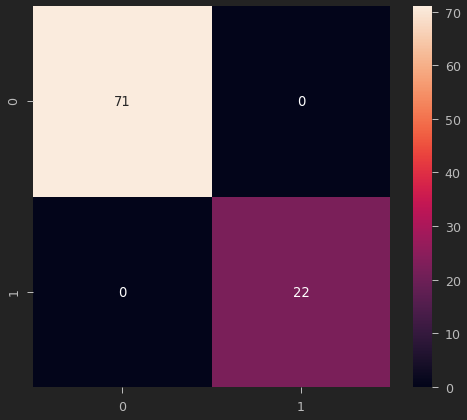

In [47]:
y_predict_train = NB_class.predict(X_train)
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm,annot = True)

<AxesSubplot:>

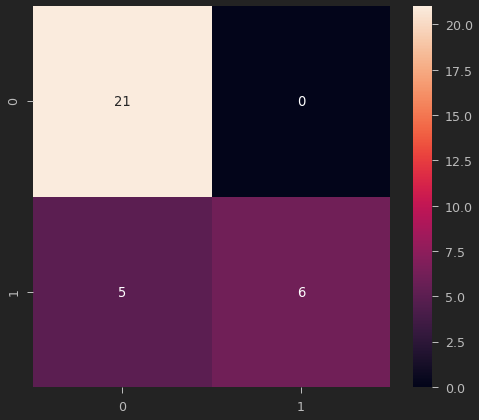

In [48]:
# plotting the confusion matrix for the test data
y_predict_test = NB_class.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm,annot = True)

In [50]:
print(classification_report(y_train, y_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        22

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



In [49]:
# Classification report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.55      0.71        11

    accuracy                           0.84        32
   macro avg       0.90      0.77      0.80        32
weighted avg       0.87      0.84      0.83        32



Overall accuracy is around 84%. We only had 125 resumes, to achieve more accuracy, we need more number of datasets.